<a href="https://colab.research.google.com/github/Manirmaths/Multidimensional-Projection/blob/main/New_metric.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
from numpy import asarray
from numpy import savetxt
from scipy.spatial.distance import cdist
from scipy.optimize import minimize
from scipy.spatial import distance
from sklearn.utils.extmath import randomized_svd
from sklearn import datasets
from sklearn.manifold import MDS,TSNE
from scipy.stats.mstats import zscore
from time import time
from sklearn import datasets
from sklearn.manifold import MDS,TSNE
from scipy.stats.mstats import zscore
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial import distance
from scipy.optimize import minimize
from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import LabelEncoder
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from math import sqrt
from sklearn import preprocessing
from collections import Counter
from sklearn.model_selection import train_test_split
%matplotlib inline

epsilon = 1e-7  

class Lamp():
    def __init__(self, Xdata = None, control_points = None, weights = None, label=False, scale=True, dim = 2):
        '''
          Xdata: N_by_K matrix where N is the number of instances and K is the dimension

          control_points: M_by_(dim + 1) matrix with the coordinates of the control points
                        in the image space. The last column contains the ids of the control
                        points in the Xdata matrix

          weights: N_by_M matrix where weights[i,j] is the weight between Xdata[i] and
                   control_point[j]. If weights=None the inverse of the Euclidean distance is used as weight

          label: when True assumes the last column of Xdata as labels

          scale: apply a transformation in the control points before accomplish the mapping.
                 Produce better projections when the original and control points coordiantes has very different scales.

          dim: dimension of the image space
        '''
        self.data = None
        self.mapped = None
        self.control_points = None
        self.control_points_data = None
        self.weights = weights
        self.dim = dim
        self.labels = None
        self.label = label
        self.scale = scale
        self.data_center = None
        self.control_points_center = None
        self.U = None
        self.S = None
        self.V = None

        if Xdata is not None:
            try:
                if type(Xdata) is not np.ndarray:
                    raise TypeError()

                if label is False:
                    self.center(Xdata,o_c_s='o')
                else:
                    self.center(Xdata[:,:-1],o_c_s='o')
                    self.labels = Xdata[:,-1].astype(int)

            except (AttributeError, TypeError):
                print('----- LAMP Error -----')
                print('Xdata must be a Numpy Array')
                sys.exit()

        if control_points is not None:
            try:
                if type(control_points) is not np.ndarray:
                    raise TypeError()

            except (AttributeError, TypeError):
                print('----- LAMP Error -----')
                print('control_points must be a Numpy Array')
                sys.exit()

            self.center(control_points,o_c_s='c')


#########
    def fit(self,Xdata=None):
        ''' decide if the mapping should be trigger with or without control points'''
        if Xdata is not None:
            try:
                if type(Xdata) is not np.ndarray:
                    raise TypeError()

                if self.data is not None:
                    if self.label is True:
                        self.center(Xdata[:,:-1],o_c_s='s')
                        self.labels = Xdata[:,-1].astype(int)
                    else:
                        self.center(Xdata,o_c_s='s')
                else:
                    if self.label is True:
                        self.center(Xdata[:,:-1],o_c_s='o')
                        self.labels = Xdata[:,-1].astype(int)
                    else:
                        self.center(Xdata,o_c_s='o')

            except (AttributeError, TypeError):
                print('----- LAMP Error -----')
                print('Type Error: Xdata must be a Numpy Array')
                sys.exit()
        else:
            try:
                if self.data is None:
                    raise ValueError()

            except ValueError:
                print('----- LAMP Error -----')
                print('No data to map')
                sys.exit()

        if self.control_points is not None:
            if (self.scale is True) and (self.S is None):
                self.scale_control_points()

            self.map()

            if self.scale is True:
                self.unscale()

            mapped = self.mapped + self.control_points_center
            if self.label is True:
                mapped = np.hstack((mapped,self.labels.reshape(self.labels.shape[0],1)))
        else:
            self.control_points_free_mapping()  # To be implemented soon
            mapped = self.mapped


        return(mapped)

#########
    def map(self):
        ''' mapping using control points '''
        n,k = self.data.shape
        m = self.control_points.shape[0]
        self.mapped = np.zeros((n,self.dim))
        ctp_mapped = self.control_points[:,:-1]
        ctp_data = self.control_points_data

        if self.weights is None:
            self.weights = cdist(self.data,ctp_data,p=2.)
            self.weights = 1.0/(self.weights+epsilon)

        for i in range(n):
            alpha = np.sum(self.weights[i])
            x_tilde = np.dot(ctp_data.T,self.weights[i].T)/alpha
            y_tilde = np.dot(ctp_mapped.T,self.weights[i].T)/alpha
            x_hat = ctp_data - x_tilde
            y_hat = ctp_mapped - y_tilde
            D = np.diag(np.sqrt(self.weights[i]))
            A = np.dot(D,x_hat)
            B = np.dot(D,y_hat)
            U,s,V = randomized_svd(np.dot(A.T,B), n_components=2, random_state=None)
            M = np.dot(U,V)
            self.mapped[i] = np.dot((self.data[i] - x_tilde),M)+y_tilde

#########
    def center(self,X,o_c_s='o'):
        '''o_c_s distriminate between original data (o), control points (c), and streaming data (s)'''
        if o_c_s == 'o':
            Xmean = np.average(X, axis=0)
            self.data_center = Xmean
            self.data = np.subtract(X,Xmean)

        if o_c_s == 'c':
            ctp_ids = X[:,-1].astype(int)
            self.control_points_data = self.data[ctp_ids]
            Xmean = np.average(X[:,0:2], axis=0)
            self.control_points_center = Xmean
            centered = np.subtract(X[:,0:2],Xmean)
            self.control_points = np.hstack((centered,X[:,-1].reshape(-1,1)))

        if o_c_s == 's':
            self.data = np.subtract(X,self.data_center)

#########
    def scale_control_points(self):
        ctp_ids = self.control_points[:,-1].astype(int)
        ctp_mapped = self.control_points[:,:-1]
        ctp_data = self.data[ctp_ids]
        Uo,So,Vo = randomized_svd(ctp_data.T, n_components=2, random_state=None)
        Uc,Sc,Vc = randomized_svd(ctp_mapped.T, n_components=2, random_state=None)
        DSo = np.diag(So)
        self.control_points[:,:-1] = np.dot(np.dot(Uc,DSo),Vc).T

        self.U = Uc
        self.S = np.diag(Sc)
        self.So = np.diag(So)
        self.V = Vc

#########
    def unscale(self):
        proj = np.dot(self.U.T,self.mapped.T)
        Sinv = np.zeros((2,2))
        Sinv[0,0] = 1.0/self.So[0,0]
        Sinv[1,1] = 1.0/self.So[1,1]
        proj_unscaled = np.dot(Sinv,proj)
        self.mapped = np.dot(self.U,np.dot(self.S,proj_unscaled)).T

#########
    def control_points_free_mapping(self):
        ''' Mapping without control points '''
        def stress(p,pt,d):
            cost = 0
            for i in range(3):
                cost += ((p[0]-pt[i,0])**2+(p[1]-pt[i,1])**2-d[i])**2
            return(cost)

        max_dist = 1e8
        n = self.data.shape[0]
        knn = 5
        self.mapped = np.zeros((n,self.dim))

        D = cdist(self.data,self.data,p=2.)

        # finding the 3 first points that give rise to the inicial triangle

        ### starting with the farthest 2 points
        idx_flat = np.argmax(D)# maximum element
        idx_i = idx_flat//n # find the row it belongs to
        idx_j = idx_flat - n*idx_i # find the column it belongs to

        ### starting with 2 random
        #idx_i = int(np.random.randint(low=0,high=n,size=1))
        #idx_j = int(np.random.randint(low=0,high=n,size=1))
        #while (idx_j == idx_i):
        #    idx_j = int(np.random.randint(low=0,high=n,size=1))

        d01 = D[idx_i,idx_j]
        d01 += epsilon
        D[idx_i,idx_j] = 0
        D[idx_j,idx_i] = 0
        processed_points = [idx_i,idx_j]

        D_processed = D[processed_points]
        idx_flat = np.argmax(D_processed)
        idx_i = idx_flat//n
        idx_j = idx_flat - n*idx_i
        d02 = D[processed_points[0],idx_j]**2 + epsilon
        d12 = D[processed_points[1],idx_j]**2 + epsilon
        D[processed_points,idx_j] = 0
        D[idx_j,processed_points] = 0
        processed_points.append(idx_j)

        # computing the initial triangle
        x = (-d12+d02+d01**2)/(2.0*d01)
        y = np.sqrt(d02-x**2)
        ltemp = [(0,0),(d01,0),(x,y)]
        proj_tri = np.asarray(ltemp)
        self.mapped[processed_points] = proj_tri[:]


        # computing k more initial points
        for i in range(3,knn):
            D_processed = D[processed_points]
            idx_flat = np.argmax(D_processed)
            idx_i = idx_flat//n
            idx_j = idx_flat - n*idx_i
            d = np.asarray([D[processed_points[0],idx_j]**2+epsilon, D[processed_points[1],idx_j]**2+epsilon, D[processed_points[2],idx_j]**2+epsilon])
            D[processed_points,idx_j] = 0
            D[idx_j,processed_points] = 0
            processed_points.append(idx_j)

            res = minimize(stress, np.asarray([0,0]),args=(proj_tri,d))
            self.mapped[idx_j] = res.x

        D = D + max_dist*np.identity(n)
        for idx_j in processed_points:
            D[processed_points,idx_j] = max_dist
            D[idx_j,processed_points] = max_dist

        # mapping the data set
        weights = np.zeros((knn,))
        for i in range(knn,n):
            D_processed = D[processed_points]
            idx_flat = np.argmin(D_processed)
            idx_i = idx_flat//n
            idx_j = idx_flat - n*idx_i

            neighbors_ids = np.argpartition(D[idx_j,processed_points],knn-1)[:knn]
            ctp_ids = [processed_points[j] for j in neighbors_ids]
            weights[:] = D[idx_j,ctp_ids]
            weights = 1.0/(weights+epsilon)
            ctp_data = self.data[ctp_ids]
            ctp_mapped = self.mapped[ctp_ids]

            alpha = np.sum(weights)
            x_tilde = np.dot(ctp_data.T,weights.T)/alpha
            y_tilde = np.dot(ctp_mapped.T,weights.T)/alpha
            x_hat = ctp_data - x_tilde
            y_hat = ctp_mapped - y_tilde
            S = np.diag(np.sqrt(weights))
            A = np.dot(S,x_hat)
            B = np.dot(S,y_hat)
            U,s,V = randomized_svd(np.dot(A.T,B), n_components=2, random_state=None)
            M = np.dot(U,V)
            self.mapped[idx_j] = np.dot((self.data[idx_j] - x_tilde),M)+y_tilde

            D[processed_points,idx_j] = max_dist
            D[idx_j,processed_points] = max_dist
            processed_points.append(idx_j)


#if __name__ == "__main__":
#    import matplotlib.pyplot as plt

[[   8.25391394    5.41666345   13.24087516   67.4299    ]
 [   5.41666345    5.45949627   14.00792903   51.3835    ]
 [  13.24087516   14.00792903 1095.0485935   116.8538    ]]
w1 =  5.709724115772122  w2 =  3.7740516009566956  w3 =  -0.010606461910166648
MAE_train=  0.541451048858895
Median_train =  0.43975525359105383
Std_train =  0.3699527754726484
MAE_test =  0.5630417465285085
Median_test =  0.4893242743985067
Std_test =  0.38779249884169015
Histogram:  (array([5., 5., 5., 2., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  ]), <a list of 16 Patch objects>)


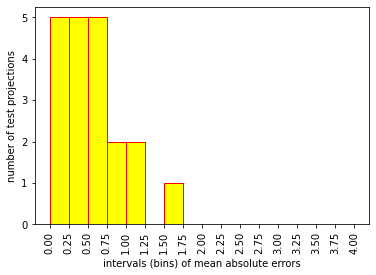

In [ ]:
#Optimization
def LU(A):
    n = len(A)
    x = np.zeros(n)
    b = np.zeros((n,1))
    for i in range(0,n):
        b[i]=A[i][n]
    L = [[0 for i in range(n)] for i in range (n)] # defined L as n by n null matrix
    for i in range(0,n):
        L[i][i]= 1# set the diagonal of matrix L with 1
    U = [[0 for i in range(n)] for i in range (n)] # defined L as n by n null matrix
    U[0][0] = A[0][0]
    for j in range(1,n,1):
        U[0][j] = A[0][j]/L[0][0]
        L[j][0] = A[j][0]/U[0][0]
    for i in range(1,n,1):
        U[i][i] = A[i][i]-sum([L[i][k]*U[k][i] for k in range(0,i)])
        for j in range(i+1,n):
            U[i][j]=1/L[i][i]*(A[i][j]-sum([L[i][k]*U[k][j] for k in range(0,i)]))
            L[j][i]=1/U[i][i]*(A[j][i]-sum([L[j][k]*U[k][i] for k in range(0,i)]))
    n = len(L)

     # Perform forward substitution for Ly = b
    y = np.zeros(n)
    for i in range(0,n,1):
        y[i] = b[i]/(L[i][i])
        for k in range(0,i,1):
            y[i] -= y[k]*L[i][k]
    n = len(U)
    c = np.zeros((n,1))
    for i in range(0,n):
        c[i]=y[i]
    Ag = np.append(U,c,axis = 1)#add column vector y to the augmented matrix
   

    #Perform backward substiution for Ux=y
    x[n-1] = Ag[n-1,n]/Ag[n-1,n-1]
    for i in range(n-2,-1,-1):
        x[i] = (Ag[i,n]-np.dot(Ag[i,i+1:n],x[i+1:n]))/Ag[i,i]
    return x
    U=np.array(U)
    L=np.array(L)
    print('The matrix A = LU = \n',np.matmul(L,U))
    print('The lower triangular matrix\n L = ',L)
    print('The upper triangular matrix\n U = ',U)
    print('The values of x are\n x = ',x)


              #################################
#f = pd.read_csv(r'metric_data1.csv')
#my_data = genfromtxt(r'metric_data1.csv', delimiter =',')
#label_encoder = LabelEncoder()
#y = label_encoder.fit_transform(f['Y'])
#my_data = np.delete(my_data, 0, axis = 0)
#x1 = np.delete(my_data, -1, axis = 1)
#x = np.delete(x1, 0, axis = 1)
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)
#print(Counter(y_train))
#print(Counter(y_test))
## Saving data to csv file

# define data
#D1 = np.hstack((X_train,y_train.reshape(y_train.shape[0],1)))
#D2 = np.hstack((X_test,y_test.reshape(y_test.shape[0],1)))
# save to csv file
#savetxt('X_train.csv', D1, delimiter=',')
#savetxt('X_test.csv', D2, delimiter=',')
# load array
#data = loadtxt('X_train.csv', delimiter=',')
# print the array
#print(data)

                    ##########################
f = pd.read_csv(r'X_train.csv')
my_data = genfromtxt(r'X_train.csv', delimiter =',')

X_train = np.delete(my_data, -1, axis = 1)
y_train = my_data[:,-1]

f1 = pd.read_csv(r'X_test.csv')
my_data1 = genfromtxt(r'X_test.csv', delimiter =',')

X_test = np.delete(my_data1, -1, axis = 1)
y_test = my_data1[:,-1]



m11 = np.sum(X_train[:,0]**2)
m12 = np.sum(X_train[:,0]*X_train[:,1])
m13 = np.sum(X_train[:,0]*X_train[:,2])
m21 = np.sum(X_train[:,1]*X_train[:,0])
m22 = np.sum(X_train[:,1]**2)
m23 = np.sum(X_train[:,1]*X_train[:,2])
m31 = np.sum(X_train[:,2]*X_train[:,0])
m32 = np.sum(X_train[:,2]*X_train[:,1])
m33 = np.sum(X_train[:,2]**2)
y1 = np.sum(y_train*X_train[:,0])
y2 = np.sum(y_train*X_train[:,1])
y3 = np.sum(y_train*X_train[:,2])
L = np.array([[m11,m12,m13,y1],[m21,m22,m23,y2],[m31,m32,m33,y3]])
print(L)
w1, w2, w3 = LU(L)
print('w1 = ',w1, ' w2 = ',w2, ' w3 = ',w3)
#cross validation
Q=[]
for i in range(X_train.shape[0]):
  Q.append(np.abs(y_train[i] - (w1*X_train[i,0]+w2*X_train[i,1]-w3*X_train[i,2])))
print('MAE_train= ',np.mean(Q))
print('Median_train = ',np.median(Q))
print('Std_train = ',np.std(Q))

J=[]
for i in range(X_test.shape[0]):
  J.append(np.abs(y_test[i] - (w1*X_test[i,0]+w2*X_test[i,1]-w3*X_test[i,2])))
print("MAE_test = ", np.mean(J))
print("Median_test = ", np.median(J))
print("Std_test = ", np.std(J))
Bins = np.linspace(0,4,17)
Bins = list(Bins)
plt.hist(J, bins=Bins, color='yellow', edgecolor='red',
              linewidth=1)
#plt.hist(exp_data, bins=21, align='left', color='b', edgecolor='red',
#              linewidth=1)
print("Histogram: ",plt.hist(J, bins=Bins, color='yellow', edgecolor='red',
              linewidth=1))
# Add axis labels /  
plt.xlabel("intervals (bins) of mean absolute errors")
plt.ylabel("number of test projections")
ax = plt.gca()
ax.set_xticks(Bins)
plt.xticks(rotation =90)
#plt.savefig('line_plot.svg')
plt.savefig('line_plot.pdf') 
plt.show()

m1 =  0.25052601196146196
m2 =  0.1550827423167849
m3 =  -0.341670763347468
sil-o =  -0.08559741374526961
new metric =  2.0193486019832534
new metric % =  0.4038697203966507


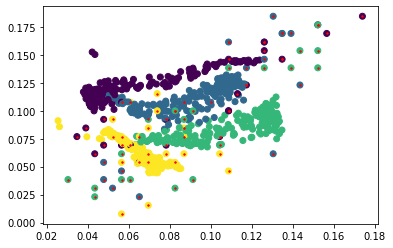

In [ ]:
from time import time
import numpy as np
from sklearn import datasets
from sklearn.manifold import MDS,TSNE
from scipy.stats.mstats import zscore
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial import distance
from scipy.optimize import minimize
from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import LabelEncoder
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from math import sqrt
from sklearn import preprocessing
%matplotlib inline
epsilon = 1e-7


#df = pd.read_csv(r'Fish_Data.csv') # read the csv file (put 'r' before the path string to address any special characters in the path, such as '\'). Don't forget to put the file name at the end of the path + ".csv"
#le = preprocessing.LabelEncoder()
#le.fit(list((df.values[:,0])))

#print(df.head())
#Z=df.values

# transform the "categorical labels" into numbers
#Z[:,0]=le.transform(list(Z[:,0]))
# Remove the NaNs that create problems by zeros
#for i in range(Z.shape[0]):
#    for j in range(Z.shape[1]):
#        if np.isnan(Z[i,j]):
#            Z[i,j]=0
#Z = Z.tolist()
#Z = np.array(Z)
#y = Z[:,0]
#X = np.delete(Z, 0, axis = 1)

#wine = datasets.load_wine()

# separate the data from the target attributes
#X = wine.data
#y = wine.target


f = pd.read_csv(r'dataset_54_vehicle.csv')
my_data = genfromtxt(r'dataset_54_vehicle.csv', delimiter =',')
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(f['Class'])
my_data = np.delete(my_data, 0, axis = 0)
X = np.delete(my_data, -1, axis = 1)

#f = pd.read_csv(r'segment_csv.csv')
#my_data = genfromtxt(r'segment_csv.csv', delimiter =',')
#label_encoder = LabelEncoder()
#y = label_encoder.fit_transform(f['class'])
#my_data = np.delete(my_data, 0, axis = 0)
#X = np.delete(my_data, -1, axis = 1)


def scaling(data, n_min = 0, n_max = 0.2):
    X_std = (data - data.min(axis =0))/(data.max(axis =0)-data.min(axis = 0)+epsilon)
    return (X_std*(n_max-n_min)+n_min)

D1 = scaling(X)
D = np.hstack((D1,y.reshape(y.shape[0],1)))

n = D.shape[0]
#sample1 = np.random.randint(low=0,high=49,size=(int(D.shape[0]/35),))
#sample2 = np.random.randint(low=50,high=99,size=(int(D.shape[0]/35),))
#sample3 = np.random.randint(low=100,high=n-1,size=(int(D.shape[0]/35),))
#sample_ids = np.append(sample1,[sample2,sample3])
sample_ids = np.random.randint(low=0,high=D.shape[0],size=(int(D.shape[0]/10),))
#sample_ids = np.random.randint(low=0,high=D.shape[0]/5,size=(int(D.shape[0]/10),))

control_points = D[sample_ids,0:2]                           # coordinates of control points
control_points = control_points

control_points = np.hstack((control_points,sample_ids.reshape(-1,1)))  # including ids of original points as the last column of control_points
lamp = Lamp(Xdata=D,control_points=control_points)
proj = lamp.fit()

#silhouette
def m1(P,y):
    m1 = silhouette_score(P,y)
    return m1
def m3(X,P,y):
    sil_mapped = silhouette_score(P,y)
    sil_data = silhouette_score(X,y)
    m3 = sil_data/sil_mapped
    return m3
def m2(X,H):
    # calculate the Euclidean distance between two vectors
    def euclidean_distance(row1, row2):
        distance = 0.0
        for i in range(len(row1)-1):
            distance += (row1[i] - row2[i])**2
        return sqrt(distance)

    # Locate the most similar neighbors
    def get_neighbors(train, test_row, num_neighbors):
        distances = list()
        for train_row in train:
            dist = euclidean_distance(test_row, train_row)
            distances.append((train_row, dist))
        distances.sort(key=lambda tup: tup[1])
        neighbors = list()
        for i in range(num_neighbors):
            neighbors.append(distances[i][0])
        return neighbors

    # Test distance function
    #dataset = [[2,3,4],[2,1,2],[6,2,3],[4,3,2]]
    B = []
    for i in range(X.shape[0]):
        neighbors = get_neighbors(X, X[i], 10)
        #for neighbor in neighbors:
        #    print(neighbor)
        A =[]
        Z = X.tolist()
        neighbors = np.asarray(neighbors)
        neighbors = neighbors.tolist()
        for neighbor in neighbors:
            A.append(Z.index(neighbor))
        A.sort()
        B.append(A)
    E = []
    for i in range(H.shape[0]):
        neighbors = get_neighbors(H, H[i], 10)
        #for neighbor in neighbors:
        #    print(neighbor)
        C =[]
        W = H.tolist()
        neighbors = np.asarray(neighbors)
        neighbors = neighbors.tolist()
        for neighbor in neighbors:
            C.append(W.index(neighbor))
        C.sort()
        E.append(C)

    l = []
    for i in range(X.shape[0]):
        M = set(E[i]) & set(B[i])
        M = list(M)
        c = len(M)
        l.append(c)    
    l = np.asarray(l)
    l = l/10
    nnp= np.sum(l)/X.shape[0]
    return nnp
m_1 = m1(proj,y)
m_2 = m2(X,proj)
m_3 = m3(X,proj,y)
new_metric = w1*m_1+w2*m_2+w3*m_3
print('m1 = ',m_1 )
print('m2 = ',m_2)
print('m3 = ', m_3)
print('sil-o = ', silhouette_score(X,y))
print('new metric = ', new_metric)
print('new metric % = ', new_metric/5)

plt.scatter(proj[:,0],proj[:,1], c=y)
plt.scatter(control_points[:,0],control_points[:,1],c='r',s=2)
plt.show()

m1 =  0.19122621413380475
m2 =  0.21516853932584268
m3 =  1.0463156410565586
new metric =  1.3788451108961288
new metric % =  0.2757690221792258


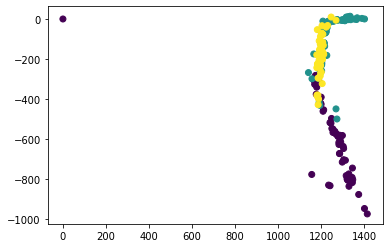

In [ ]:

#f = pd.read_csv(r'dataset_54_vehicle.csv')
#my_data = genfromtxt(r'dataset_54_vehicle.csv', delimiter =',')
#label_encoder = LabelEncoder()
#Y = label_encoder.fit_transform(f['Class'])
#my_data = np.delete(my_data, 0, axis = 0)
#X = np.delete(my_data, -1, axis = 1)

iris = datasets.load_wine()

X = iris.data
Y = iris.target

def scaled(data):
    Xmean = np.average(data, axis=0)
    dat = np.subtract(data,Xmean)
    Uo,So,Vo = randomized_svd(dat.T, n_components=2, random_state=None)
    DSo = np.diag(So)
    return (np.dot(np.dot(Uo,DSo),Vo).T)



            
def scaling(data, n_min = 0, n_max = 1):
    X_std = (data - data.min(axis =0))/(data.max(axis =0)-data.min(axis = 0)+epsilon)
    return (X_std*(n_max-n_min)+n_min)

D1 = scaling(X)
D = np.hstack((X,Y.reshape(Y.shape[0],1)))
data = D

dim = 2

#data = X
max_dist = 1e8
n = data.shape[0]
knn = 5
mapped = np.zeros((n,dim))
D = cdist(data,data,p=2.)
idx_flat = np.argmax(D)
idx_i = idx_flat//n
idx_j = idx_flat - n*idx_i
idx_i,idx_j
d01 = D[idx_i,idx_j]
d01 += epsilon
D[idx_i,idx_j] = 0
D[idx_j,idx_i] = 0
processed_points = [idx_i,idx_j]
D_processed = D[processed_points]
idx_flat = np.argmax(D_processed)
idx_i = idx_flat//n
idx_j = idx_flat - n*idx_i
d02 = D[processed_points[0],idx_j]**2+epsilon
d12 = D[processed_points[1],idx_j]**2+epsilon
D[processed_points,idx_j] = 0
D[idx_j,processed_points] = 0
processed_points.append(idx_j)
#print(processed_points)
x = (-d12+d02+d01**2)/(2.0*d01)
y = np.sqrt(np.abs(d02-x**2))
ltemp = [(0,0),(d01,0),(x,y)]
proj_tri = np.asarray(ltemp)
mapped[processed_points] = proj_tri[:]
#print(x,y)
#print(proj_tri)
def stress(p,pt,d):
    cost = 0
    for i in range(3):
        cost += ((p[0]-pt[i,0])**2+(p[1]-pt[i,1])**2-d[i])**2
    return(cost)
for i in range(3,knn):
    D_processed = D[processed_points]
    idx_flat = np.argmax(D_processed)
    idx_i = idx_flat//n
    idx_j = idx_flat - n*idx_i
    # d is the array of distance for  our 3 points to the new point
    d = np.asarray([D[processed_points[0],idx_j]**2+epsilon, D[processed_points[1],idx_j]**2+epsilon, D[processed_points[2],idx_j]**2+epsilon])
    D[processed_points,idx_j] = 0
    D[idx_j,processed_points] = 0
    processed_points.append(idx_j)

    res = minimize(stress, np.asarray([0,0]),args=(proj_tri,d))
    mapped[idx_j] = res.x

#print(d)
#print(mapped)
D = D + max_dist*np.identity(n)
for idx_j in processed_points:
    D[processed_points,idx_j] = max_dist
    D[idx_j,processed_points] = max_dist
weights = np.zeros((knn,))
for i in range(knn,n):
    D_processed = D[processed_points]
    idx_flat = np.argmin(D_processed)
    idx_i = idx_flat//n
    idx_j = idx_flat - n*idx_i

    neighbors_ids = np.argpartition(D[idx_j,processed_points],knn-1)[:knn]
    ctp_ids = [processed_points[j] for j in neighbors_ids]
    weights[:] = D[idx_j,ctp_ids]
    weights = 1.0/(weights+epsilon)
    ctp_data = data[ctp_ids]
    ctp_mapped = mapped[ctp_ids]

    alpha = np.sum(weights)
    x_tilde = np.dot(ctp_data.T,weights.T)/alpha
    y_tilde = np.dot(ctp_mapped.T,weights.T)/alpha
    x_hat = ctp_data - x_tilde
    y_hat = ctp_mapped - y_tilde
    S = np.diag(np.sqrt(weights))
    A = np.dot(S,x_hat)
    B = np.dot(S,y_hat)
    U,s,V = randomized_svd(np.dot(A.T,B), n_components=2, random_state=None)
    M = np.dot(U,V)
    mapped[idx_j] = np.dot((data[idx_j] - x_tilde),M)+y_tilde

    D[processed_points,idx_j] = max_dist
    D[idx_j,processed_points] = max_dist
    processed_points.append(idx_j)

S = []
V = []
H = []
n = data.shape[0]
for j in range(n):
    for i in range(j+1,n):
        S.append(distance.euclidean(data[j],data[i]))
m=len(S)
for j in range(n):
    for i in range(j+1,n):
        V.append(distance.euclidean(mapped[j],mapped[i]))
for i in range (m):
    H.append((S[i]-V[i])**2)
S2 = list()
for i in range(m):
    S2.append(S[i]**2)
stress = sum(H)/sum(S2)
xmean = np.average(X[:,0:2], axis=0)
#mapped = mapped+xmean
sil = silhouette_score(mapped,data[:,-1])
#print('Stress:',stress,'\n')
#print('Silhouette',sil)


#silhouette
def m1(P,y):
    m1 = silhouette_score(P,y)
    return m1
def m3(X,P,y):
    sil_mapped = silhouette_score(P,y)
    sil_data = silhouette_score(X,y)
    m3 = sil_data/sil_mapped
    return m3
def m2(X,H):
    # calculate the Euclidean distance between two vectors
    def euclidean_distance(row1, row2):
        distance = 0.0
        for i in range(len(row1)-1):
            distance += (row1[i] - row2[i])**2
        return sqrt(distance)

    # Locate the most similar neighbors
    def get_neighbors(train, test_row, num_neighbors):
        distances = list()
        for train_row in train:
            dist = euclidean_distance(test_row, train_row)
            distances.append((train_row, dist))
        distances.sort(key=lambda tup: tup[1])
        neighbors = list()
        for i in range(num_neighbors):
            neighbors.append(distances[i][0])
        return neighbors

    # Test distance function
    #dataset = [[2,3,4],[2,1,2],[6,2,3],[4,3,2]]
    B = []
    for i in range(X.shape[0]):
        neighbors = get_neighbors(X, X[i], 10)
        #for neighbor in neighbors:
        #    print(neighbor)
        A =[]
        Z = X.tolist()
        neighbors = np.asarray(neighbors)
        neighbors = neighbors.tolist()
        for neighbor in neighbors:
            A.append(Z.index(neighbor))
        A.sort()
        B.append(A)
    E = []
    for i in range(H.shape[0]):
        neighbors = get_neighbors(H, H[i], 10)
        #for neighbor in neighbors:
        #    print(neighbor)
        C =[]
        W = H.tolist()
        neighbors = np.asarray(neighbors)
        neighbors = neighbors.tolist()
        for neighbor in neighbors:
            C.append(W.index(neighbor))
        C.sort()
        E.append(C)

    l = []
    for i in range(X.shape[0]):
        M = set(E[i]) & set(B[i])
        M = list(M)
        c = len(M)
        l.append(c)    
    l = np.asarray(l)
    l = l/10
    nnp= np.sum(l)/X.shape[0]
    return nnp
m_1 = m1(mapped,Y)
m_2 = m2(X,mapped)
m_3 = m3(X,mapped,Y)
new_metric = w1*m_1+w2*m_2+w3*m_3
print('m1 = ',m_1 )
print('m2 = ',m_2)
print('m3 = ', m_3)
#print('sil-o = ', silhouette_score(X,Y))
print('new metric = ', new_metric)
print('new metric % = ', new_metric/5)

plt.scatter(mapped[:,0],mapped[:,1],c=data[:,-1])
plt.show()

In [ ]:
#C = np.array([0.001,0.01,0.1,1,10,10,100,1000])
C = np.linspace(0.01,100,100)
iris = datasets.load_wine()
X = iris.data
Y = iris.target
B = []
for s in C:
  def scaling(data, n_min = 0, n_max = s):
    X_std = (data - data.min(axis =0))/(data.max(axis =0)-data.min(axis = 0)+epsilon)
    return (X_std*(n_max-n_min)+n_min)
  D1 = scaling(X)
  D = np.hstack((D1,Y.reshape(Y.shape[0],1)))
  B.append(D)

Interval: [0, 0.1 ]  new metric =  2.5341176555753253


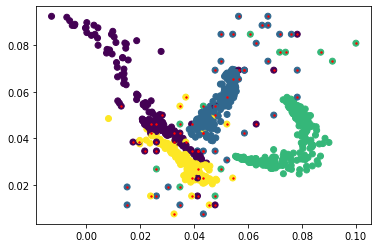

Interval: [0, 0.2 ]  new metric =  2.7435099502957643


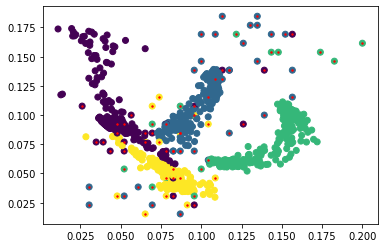

Interval: [0, 0.30000000000000004 ]  new metric =  2.6663077513863587


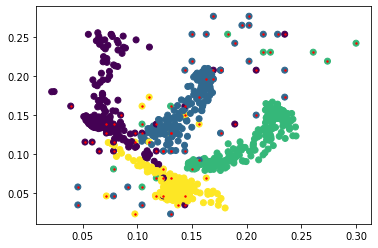

Interval: [0, 0.4 ]  new metric =  2.4948451432047163


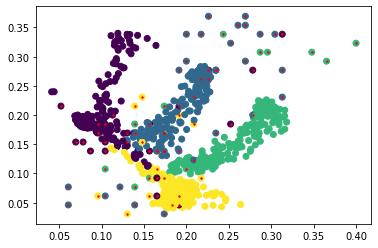

Interval: [0, 0.5 ]  new metric =  2.2579971094085285


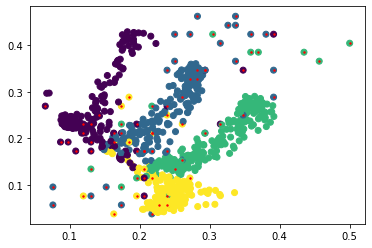

Interval: [0, 0.6 ]  new metric =  2.013230151790747


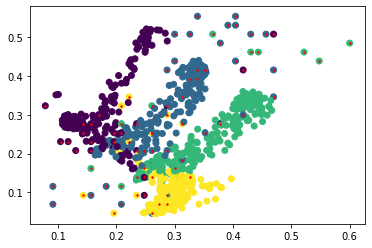

Interval: [0, 0.7000000000000001 ]  new metric =  1.780240067157736


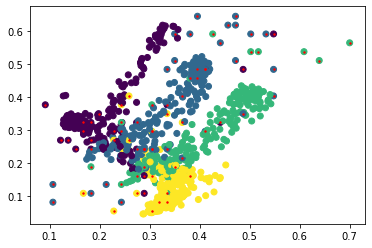

Interval: [0, 0.8 ]  new metric =  1.585201989186423


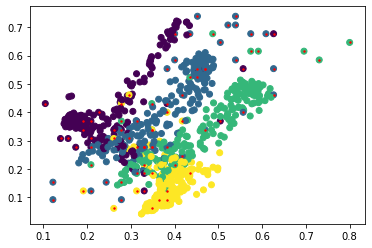

Interval: [0, 0.9 ]  new metric =  1.4195451946458244


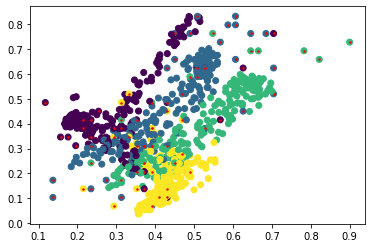

Interval: [0, 1.0 ]  new metric =  1.2735100600022558


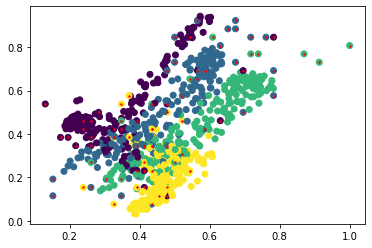

In [ ]:
from time import time
import numpy as np
from sklearn import datasets
from sklearn.manifold import MDS,TSNE
from scipy.stats.mstats import zscore
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.spatial import distance
from scipy.optimize import minimize
from sklearn.utils.extmath import randomized_svd
from sklearn.preprocessing import LabelEncoder
from numpy import genfromtxt
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from math import sqrt
from sklearn import preprocessing
%matplotlib inline
epsilon = 1e-7

#C = np.linspace(0.01,0.1,10)
C = np.linspace(0.1,1,10)
#C = np.array([0.001,0.01,0.1,1,10,100,1000])
#wine = datasets.load_wine()

# separate the data from the target attributes
#X = wine.data
#y = wine.target

f = pd.read_csv(r'dataset_54_vehicle.csv')
my_data = genfromtxt(r'dataset_54_vehicle.csv', delimiter =',')
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(f['Class'])
my_data = np.delete(my_data, 0, axis = 0)
X = np.delete(my_data, -1, axis = 1)


#f = pd.read_csv(r'segment_csv.csv')
#my_data = genfromtxt(r'segment_csv.csv', delimiter =',')
#label_encoder = LabelEncoder()
#y = label_encoder.fit_transform(f['class'])
#my_data = np.delete(my_data, 0, axis = 0)
#X = np.delete(my_data, -1, axis = 1)

T = []
for s in C:
  def scaling(data, n_min = 0, n_max = s):
    X_std = (data - data.min(axis =0))/(data.max(axis =0)-data.min(axis = 0)+epsilon)
    return (X_std*(n_max-n_min)+n_min)


  D1 = scaling(X)
  D = np.hstack((D1,y.reshape(y.shape[0],1)))

  n = D.shape[0]
  #sample1 = np.random.randint(low=0,high=49,size=(int(D.shape[0]/35),))
  #sample2 = np.random.randint(low=50,high=99,size=(int(D.shape[0]/35),))
  #sample3 = np.random.randint(low=100,high=n-1,size=(int(D.shape[0]/35),))
  #sample_ids = np.append(sample1,[sample2,sample3])
  #sample_ids = np.random.randint(low=0,high=D.shape[0],size=(int(D.shape[0]/10),))
  #sample_ids = np.random.randint(low=0,high=D.shape[0]/5,size=(int(D.shape[0]/10),))

  control_points = D[sample_ids,0:2]                           # coordinates of control points
  control_points = control_points

  control_points = np.hstack((control_points,sample_ids.reshape(-1,1)))  # including ids of original points as the last column of control_points
  lamp = Lamp(Xdata=D,control_points=control_points)
  proj = lamp.fit()

  #silhouette
  def m1(P,y):
      m1 = silhouette_score(P,y)
      return m1
  def m3(X,P,y):
      sil_mapped = silhouette_score(P,y)
      sil_data = silhouette_score(X,y)
      m3 = sil_data/sil_mapped
      return m3
  def m2(X,H):
      # calculate the Euclidean distance between two vectors
      def euclidean_distance(row1, row2):
          distance = 0.0
          for i in range(len(row1)-1):
              distance += (row1[i] - row2[i])**2
          return sqrt(distance)

      # Locate the most similar neighbors
      def get_neighbors(train, test_row, num_neighbors):
          distances = list()
          for train_row in train:
              dist = euclidean_distance(test_row, train_row)
              distances.append((train_row, dist))
          distances.sort(key=lambda tup: tup[1])
          neighbors = list()
          for i in range(num_neighbors):
              neighbors.append(distances[i][0])
          return neighbors

      # Test distance function
      #dataset = [[2,3,4],[2,1,2],[6,2,3],[4,3,2]]
      B = []
      for i in range(X.shape[0]):
          neighbors = get_neighbors(X, X[i], 10)
          #for neighbor in neighbors:
          #    print(neighbor)
          A =[]
          Z = X.tolist()
          neighbors = np.asarray(neighbors)
          neighbors = neighbors.tolist()
          for neighbor in neighbors:
              A.append(Z.index(neighbor))
          A.sort()
          B.append(A)
      E = []
      for i in range(H.shape[0]):
          neighbors = get_neighbors(H, H[i], 10)
          #for neighbor in neighbors:
          #    print(neighbor)
          C =[]
          W = H.tolist()
          neighbors = np.asarray(neighbors)
          neighbors = neighbors.tolist()
          for neighbor in neighbors:
              C.append(W.index(neighbor))
          C.sort()
          E.append(C)

      l = []
      for i in range(X.shape[0]):
          M = set(E[i]) & set(B[i])
          M = list(M)
          c = len(M)
          l.append(c)    
      l = np.asarray(l)
      l = l/10
      nnp= np.sum(l)/X.shape[0]
      return nnp
  m_1 = m1(proj,y)
  m_2 = m2(X,proj)
  m_3 = m3(X,proj,y)
  new_metric = w1*m_1+w2*m_2+w3*m_3
  #print('m1 = ',m_1 )
  #print('m2 = ',m_2)
  #print('m3 = ', m_3)
  #print('sil-o = ', silhouette_score(X,y))
  print("Interval:", '[0,',s,']',' new metric = ', new_metric)
  #print('new metric % = ', new_metric/5)
  T.append(new_metric)
  plt.scatter(proj[:,0],proj[:,1], c=y)
  plt.scatter(control_points[:,0],control_points[:,1],c='r',s=2)
  plt.show()

In [ ]:
#np.max(T)
T.index(np.max(T))

3

In [ ]:
T[3]

1.8523497181951813

In [ ]:
C = np.linspace(0.01,0.1,10)
C = list(C)
C

[0.01,
 0.020000000000000004,
 0.030000000000000006,
 0.04000000000000001,
 0.05000000000000001,
 0.06000000000000001,
 0.07,
 0.08,
 0.09000000000000001,
 0.1]

In [ ]:
if C[6]-C[7] == C[4]-C[5]:
  print('true')

true


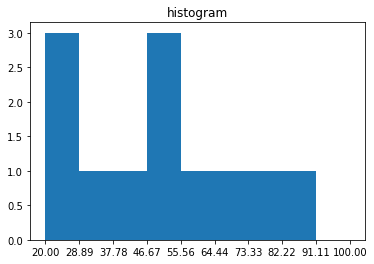

In [ ]:
from matplotlib import pyplot as plt 
import numpy as np  
   
a = np.array([22,87,5,43,56,73,55,54,11,20,51,5,79,31,27]) 
plt.hist(a, bins = C)
ax = plt.gca()
ax.set_xticks(C)
plt.title("histogram") 
plt.show()

In [ ]:
J

[0.5069941915231804,
 0.7235607354965303,
 0.28045672919454434,
 0.471654357273833,
 1.6201452902605973,
 0.39239619392427816,
 0.9960912193498359,
 0.22210566848070368,
 0.07417114065689664,
 0.2131077530126655,
 1.0207989275306124,
 0.1879396591968714,
 1.1672829814608785,
 0.18144199699294106,
 0.30639050887790287,
 0.5474562618014598,
 0.8138329430009259,
 0.6793255892506425,
 0.5669155552893395,
 0.2887672279955309]

In [ ]:
Bins

[0.0,
 0.25,
 0.5,
 0.75,
 1.0,
 1.25,
 1.5,
 1.75,
 2.0,
 2.25,
 2.5,
 2.75,
 3.0,
 3.25,
 3.5,
 3.75,
 4.0,
 4.25,
 4.5,
 4.75,
 5.0]